#### DL-Assignment2 -Group 146

Import Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pandas as pd
import pickle

Download Image files and Pickle File for caption Annotations

In [3]:
from google.colab import drive
import zipfile as zip1

drive.mount('/content/drive')
zip_ref = zip1.ZipFile('./drive/My Drive/Image_captioning_Dataset.zip', 'r')
zip_ref.extractall('dataset/')
zip_ref.close()

Mounted at /content/drive


In [4]:
data = pd.read_pickle('./drive/My Drive/set_0.pkl')
images = ['/content/dataset/Flicker8k_Dataset/'+val.split('#')[0] for val in data] 
captions = ["<start> "+ val.split('\t')[1] +" <end>" for val in data]
Image_exists = [os.path.isfile('/content/dataset/Flicker8k_Dataset/'+val.split('#')[0]) for val in data] 
descriptions = pd.DataFrame(pd.DataFrame(list(zip(images,captions,Image_exists))))

In [5]:
FinalData = descriptions[descriptions[2]==True]

In [6]:
len([[x,list(FinalData[0]).count(x)] for x in set(list(FinalData[0]))])

8036

Group all captions together having the same image ID.

 Select the first 6000 image_paths from the shuffled set.
 Approximately each image id has 5 captions associated with it, so that will
lead to 30,000 examples.

Train test Split

In [7]:
distinct_imgs = list(set(list(FinalData[0])))
random.shuffle(distinct_imgs)

train_image_paths = distinct_imgs[:6000]
test_image_paths = distinct_imgs[6000:7000]
val_image_paths = distinct_imgs[7000:]
print(len(train_image_paths))
print(len(test_image_paths))
print(len(val_image_paths))

trainData = FinalData[FinalData[0].isin(train_image_paths)]
testData = FinalData[FinalData[0].isin(test_image_paths)]
valData = FinalData[FinalData[0].isin(val_image_paths)]

6000
1000
1036


Sample Train Image and caption

/content/dataset/Flicker8k_Dataset/318667317_108c402140.jpg
<start> A man in a black hoodie be hold a paper sign . <end>


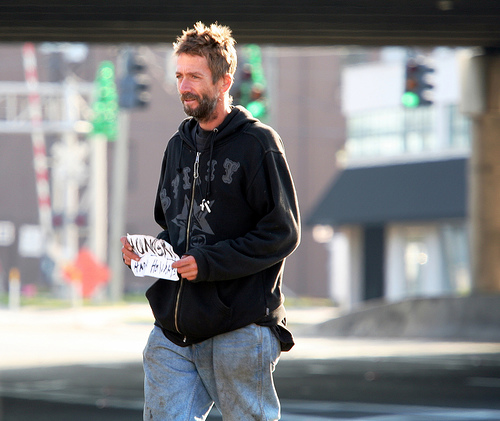

In [8]:
print(FinalData[0][0])
print(FinalData[1][0])
Image.open(FinalData[0][0])

Function to load images

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

Feature extraction model

In [10]:
image_model = tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
encode_train = sorted(set(trainData[0]))

In [12]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [13]:
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [14]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(trainData[1])

In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [17]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(trainData[1])

In [18]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [19]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [20]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(trainData[0], cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(14909, 14909, 3740, 3740)

In [22]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49

In [23]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [27]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [28]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [29]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [30]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [31]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [32]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [33]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [34]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.9557
Epoch 1 Batch 100 Loss 1.4648
Epoch 1 Batch 200 Loss 1.2459
Epoch 1 Loss 1.572078
Time taken for 1 epoch 815.77 sec

Epoch 2 Batch 0 Loss 1.2786
Epoch 2 Batch 100 Loss 1.2223
Epoch 2 Batch 200 Loss 1.2588
Epoch 2 Loss 1.210351
Time taken for 1 epoch 744.08 sec

Epoch 3 Batch 0 Loss 1.0235
Epoch 3 Batch 100 Loss 0.9534
Epoch 3 Batch 200 Loss 0.9910
Epoch 3 Loss 1.076690
Time taken for 1 epoch 745.93 sec

Epoch 4 Batch 0 Loss 0.9855
Epoch 4 Batch 100 Loss 0.9470
Epoch 4 Batch 200 Loss 0.9381
Epoch 4 Loss 0.986367
Time taken for 1 epoch 745.10 sec

Epoch 5 Batch 0 Loss 0.8931
Epoch 5 Batch 100 Loss 0.8748
Epoch 5 Batch 200 Loss 0.8801
Epoch 5 Loss 0.912281
Time taken for 1 epoch 742.23 sec



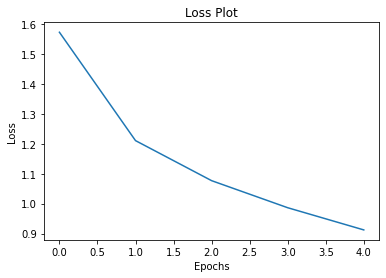

In [35]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [36]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [62]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    fig2 = plt.figure(image)

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


 Real Caption: <start> girl in orange shirt lighting white candle <end> 



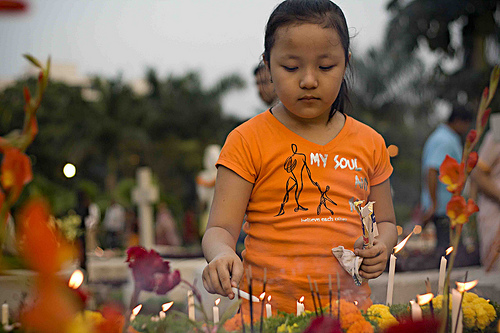

In [83]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
print('\n Real Caption:', real_caption,'\n')
Image.open(image)


 Prediction Caption: girl in front of one in a field for a colorful <end> 



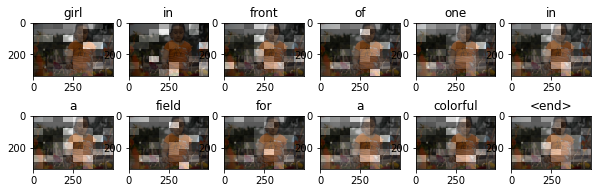

<Figure size 432x288 with 0 Axes>

In [84]:
result, attention_plot = evaluate(image)
print('\n Prediction Caption:', ' '.join(result), '\n')
plot_attention(image, result, attention_plot)


 Real Caption: <start> a man dress as a clown ride a bicycle in a race <end> 



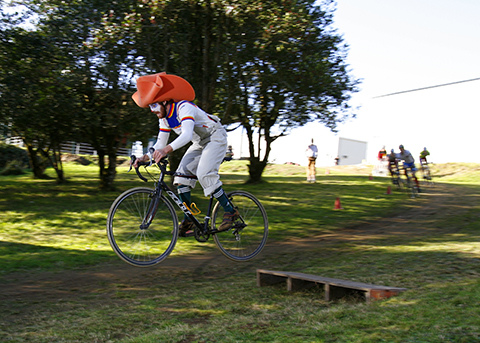

In [81]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
print('\n Real Caption:', real_caption,'\n')
Image.open(image)


 Prediction Caption: boy ride one be take a bike <end> 



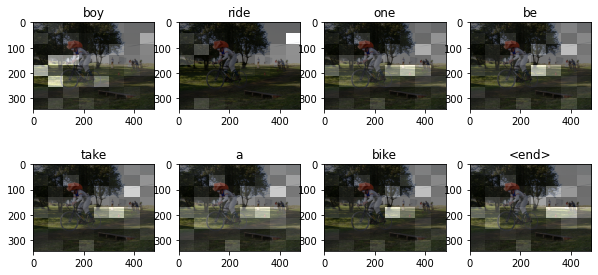

<Figure size 432x288 with 0 Axes>

In [82]:
result, attention_plot = evaluate(image)
print('\n Prediction Caption:', ' '.join(result), '\n')
plot_attention(image, result, attention_plot)


 Real Caption: <start> a girl in the purple top and short wear a hat be laugh <end> 



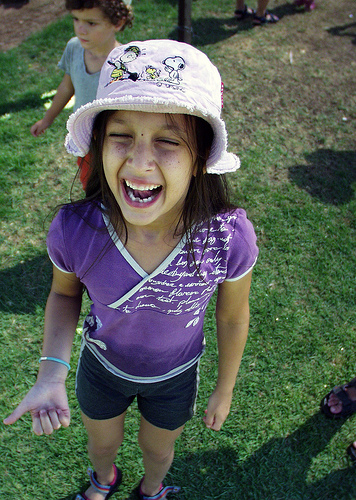

In [79]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
print('\n Real Caption:', real_caption,'\n')
Image.open(image)


 Prediction Caption: a young girl in a sprinkler <end> 



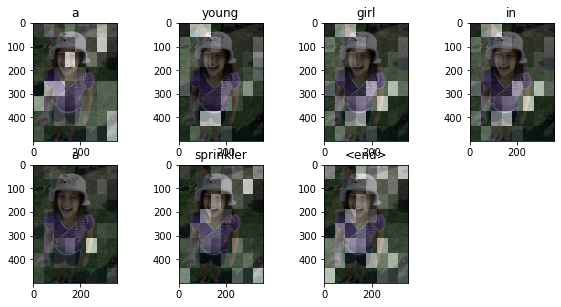

<Figure size 432x288 with 0 Axes>

In [80]:
result, attention_plot = evaluate(image)
print('\n Prediction Caption:', ' '.join(result), '\n')
plot_attention(image, result, attention_plot)